In [1]:
import os
from pathlib import Path

path = Path(os.getcwd()).parent
src_path = str(path/"src")
sys.path.append(src_path)

%env TPU_NAME=tpunode1

env: TPU_NAME=tpunode1


In [2]:
import json
import sys

import numpy as np
import tensorflow as tf
import yaml
from matplotlib import pyplot as plt
from models.xception_ft_model import create_xception_ft_model
from pipeline.train_utils import (
    MapDict,
    get_training_dataset,
    get_validation_dataset,
    load_dataset,
    lrfn,
    to_float32,
)

print("tensorflow", tf.__version__)


tensorflow 2.4.1


## Load config

In [3]:
params_path = str(path/"params.yaml")

with open(params_path, "r") as params_file:
    params = yaml.load(params_file)
dataset_config = MapDict(params["dataset"])
split_config = MapDict(params["split"])
train_config = MapDict(params["train"])
print("dataset:\n\n", dataset_config)
print()
print("split:\n\n", split_config)
print()
print("train:\n\n", train_config)

dataset:

 {'image_size': 331, 'gcs_path': 'gs://kaggle-data-tpu/images', 'gcs_path_remote_alias': 'gcs_images', 'classes': ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']}

split:

 {'train_split_path': 'data/interim/train_split.json', 'val_split_path': 'data/interim/val_split.json', 'images_count_path': 'data/interim/images_count.json', 'validation_split': 0.19}

train:

 {'nb_validation_samples': 800, 'epochs': 10, 'batch_size': 16, 'lr': {'start': 1e-05, 'max': 5e-05, 'min': 1e-05, 'rampup_epochs': 5, 'sustain_epochs': 0, 'exp_decay': 0.8}}


## Load validation split files

## Display images utils

In [17]:
def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
    
def dataset_to_numpy_util(dataset, N):
    dataset = dataset.unbatch().batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;  
    return numpy_images, numpy_labels

def dataset_to_numpy_util(dataset, N):
    dataset = dataset.unbatch().batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;  
    return numpy_images, numpy_labels

def display_9_images_from_dataset(dataset):
    subplot=331
    plt.figure(figsize=(13,13))
    images, labels = dataset_to_numpy_util(dataset, 9)
    for i, image in enumerate(images):
        title = dataset_config.classes[np.argmax(labels[i], axis=-1)]
        subplot = display_one_flower(image, title, subplot)
        if i >= 8:
            break
              
    #plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

In [14]:
train_split_path = str(path / split_config.train_split_path)
val_split_path = str(path / split_config.val_split_path)

with open(train_split_path, "r") as train_split_file, open(val_split_path, "r") as val_split_file:
    train_split_files = json.load(train_split_file)
    val_split_files = json.load(val_split_file)

train_split_files, val_split_files

(['gs://kaggle-data-tpu/images/tfrecords-jpeg-331x331/flowers00-230.tfrec',
  'gs://kaggle-data-tpu/images/tfrecords-jpeg-331x331/flowers01-230.tfrec',
  'gs://kaggle-data-tpu/images/tfrecords-jpeg-331x331/flowers02-230.tfrec',
  'gs://kaggle-data-tpu/images/tfrecords-jpeg-331x331/flowers03-230.tfrec',
  'gs://kaggle-data-tpu/images/tfrecords-jpeg-331x331/flowers04-230.tfrec',
  'gs://kaggle-data-tpu/images/tfrecords-jpeg-331x331/flowers05-230.tfrec',
  'gs://kaggle-data-tpu/images/tfrecords-jpeg-331x331/flowers06-230.tfrec',
  'gs://kaggle-data-tpu/images/tfrecords-jpeg-331x331/flowers07-230.tfrec',
  'gs://kaggle-data-tpu/images/tfrecords-jpeg-331x331/flowers08-230.tfrec',
  'gs://kaggle-data-tpu/images/tfrecords-jpeg-331x331/flowers09-230.tfrec',
  'gs://kaggle-data-tpu/images/tfrecords-jpeg-331x331/flowers10-230.tfrec',
  'gs://kaggle-data-tpu/images/tfrecords-jpeg-331x331/flowers11-230.tfrec',
  'gs://kaggle-data-tpu/images/tfrecords-jpeg-331x331/flowers12-230.tfrec'],
 ['gs://kag

### Load training set images

In [20]:
train_dataset = get_training_dataset(
    train_split_files, dataset_config.image_size, train_config.batch_size
)
train_dataset

<PrefetchDataset shapes: ((None, 331, 331, 3), (None, 5)), types: (tf.uint8, tf.float32)>

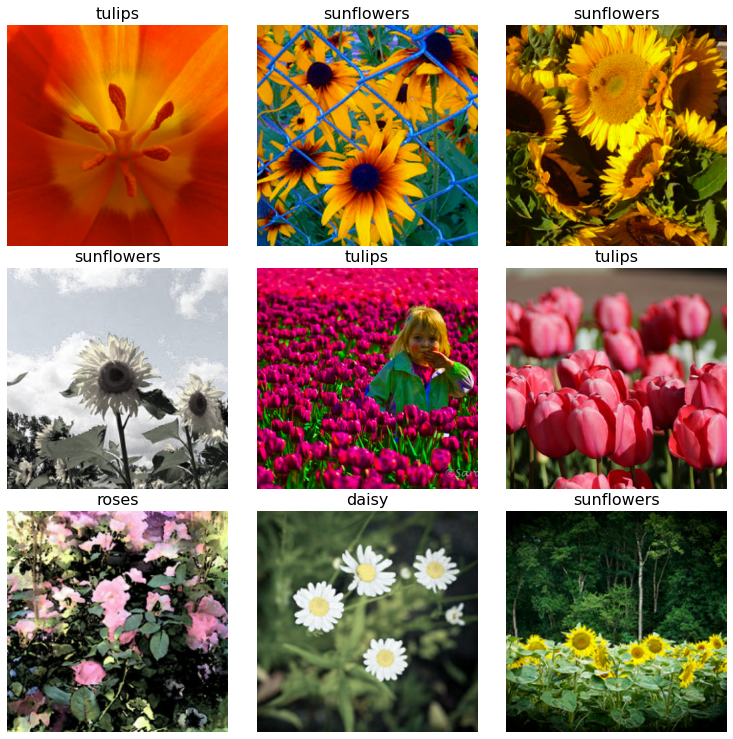

In [21]:
display_9_images_from_dataset(train_dataset)

## Load validation set images

In [5]:
val_dataset = get_validation_dataset(
    val_split_files, dataset_config.image_size, train_config.batch_size
)
val_dataset

<PrefetchDataset shapes: ((None, 331, 331, 3), (None, 5)), types: (tf.uint8, tf.float32)>

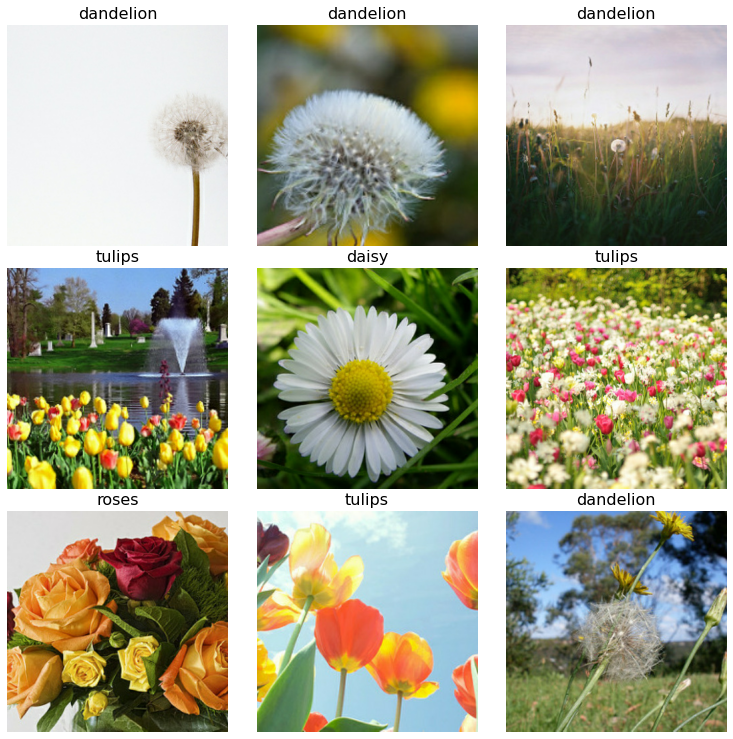

In [7]:
display_9_images_from_dataset(val_dataset)

## TPU detection

In [23]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.MirroredStrategy()
print("Number of accelerators", strategy.num_replicas_in_sync)


INFO:tensorflow:Initializing the TPU system: tpunode1
INFO:tensorflow:Initializing the TPU system: tpunode1
INFO:tensorflow:Clearing out eager caches
INFO:tensorflow:Clearing out eager caches
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(

### Training

In [24]:
num_classes = len(dataset_config.classes)
with strategy.scope():
    model = create_xception_ft_model(dataset_config.image_size, num_classes)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 331, 331, 3)       0         
_________________________________________________________________
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 20,871,725
Trainable params: 20,817,197
Non-trainable params: 54,528
_________________________________________________________________


TPU requires data to be in float32 format

In [25]:
training_dataset = get_training_dataset().map(to_float32)
validation_dataset = get_validation_dataset().map(to_float32)

TypeError: get_training_dataset() missing 3 required positional arguments: 'training_files_path', 'image_size', and 'batch_size'